In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def brusselator(t, state, a=1.0, b=3.0):
    x, y = state
    return np.array([1.0 - (b + 1.0) * x + a * x * x * y,
                     b * x - a * x * x * y], dtype=float)

def modified_midpoint_step(f, t, y, h, n):
    dt = h / n
    y0 = y
    y1 = y0 + dt * f(t, y0)
    tt = t + dt
    for _ in range(2, n + 1):
        y2 = y0 + 2.0 * dt * f(tt, y1)
        y0, y1 = y1, y2
        tt += dt
    return 0.5 * (y0 + y1 + dt * f(t + h, y1))

def bulirsch_stoer_step(f, t, y, h, tol, n_max=8):
    ns = list(range(2, n_max + 1, 2))
    romb = []
    last = None
    tol_vec = np.full_like(y, tol * abs(h))
    for i, n in enumerate(ns):
        y_mm = modified_midpoint_step(f, t, y, h, n)
        romb.append([y_mm])
        for k in range(1, i + 1):
            r = (ns[i] / ns[i - k]) ** 2
            yk = romb[i][k - 1] + (romb[i][k - 1] - romb[i - 1][k - 1]) / (r - 1.0)
            romb[i].append(yk)
        y_extr = romb[i][-1]
        if last is not None:
            err = np.abs(y_extr - last)
            if np.all(err <= tol_vec):
                return True, y_extr, np.max(err / tol_vec)
        last = y_extr
    err = np.abs(romb[-1][-1] - romb[-1][-2]) if len(romb[-1]) > 1 else np.abs(romb[0][0] - y)
    return False, last, np.max(err / tol_vec)

def integrate_brusselator(t0=0.0, t1=20.0, x0=0.0, y0=0.0, a=1.0, b=3.0,
                          H=20.0, delta=1e-8, n_max=8, h_min=1e-12, h_max=None):
    if h_max is None:
        h_max = H
    t = t0
    y = np.array([x0, y0], dtype=float)
    h = np.sign(t1 - t0) * H
    ts, xs, ys, edges = [t], [y[0]], [y[1]], [t]
    accepted = rejected = 0
    rhs = lambda tt, yy: brusselator(tt, yy, a, b)
    while (t < t1 and h > 0) or (t > t1 and h < 0):
        if (t + h > t1 and h > 0) or (t + h < t1 and h < 0):
            h = t1 - t
        ok, y_new, r = bulirsch_stoer_step(rhs, t, y, h, delta, n_max=n_max)
        if ok:
            t += h
            y = y_new
            ts.append(t); xs.append(y[0]); ys.append(y[1]); edges.append(t)
            accepted += 1
            if r < 0.1 and abs(h) < abs(h_max):
                h = np.sign(h) * min(abs(2.0 * h), abs(h_max))
            else:
                s = 0.9 * (1.0 / max(r, 1e-16)) ** 0.25
                s = min(2.0, max(0.5, s))
                h = np.sign(h) * min(abs(h_max), max(abs(h_min), abs(h) * s))
        else:
            h *= 0.5
            rejected += 1
            if abs(h) < h_min:
                raise RuntimeError("Step size underflow")
    return {"t": np.array(ts), "x": np.array(xs), "y": np.array(ys),
            "boundaries": np.array(edges), "accepted": accepted, "rejected": rejected}

In [13]:
soln = integrate_brusselator(a=1.0, b=3.0, t0=0.0, t1=20.0,
                            x0=0.0, y0=0.0, H=20.0, delta=1e-8,
                            n_max=8, h_max=40.0)

C:\Users\ashyu\AppData\Local\Temp\ipykernel_35932\3498329661.py:6: RuntimeWarning: overflow encountered in double_scalars
  return np.array([1.0 - (b + 1.0) * x + a * x * x * y,
C:\Users\ashyu\AppData\Local\Temp\ipykernel_35932\3498329661.py:7: RuntimeWarning: overflow encountered in double_scalars
  b * x - a * x * x * y], dtype=float)
C:\Users\ashyu\AppData\Local\Temp\ipykernel_35932\3498329661.py:18: RuntimeWarning: invalid value encountered in add
  return 0.5 * (y0 + y1 + dt * f(t + h, y1))


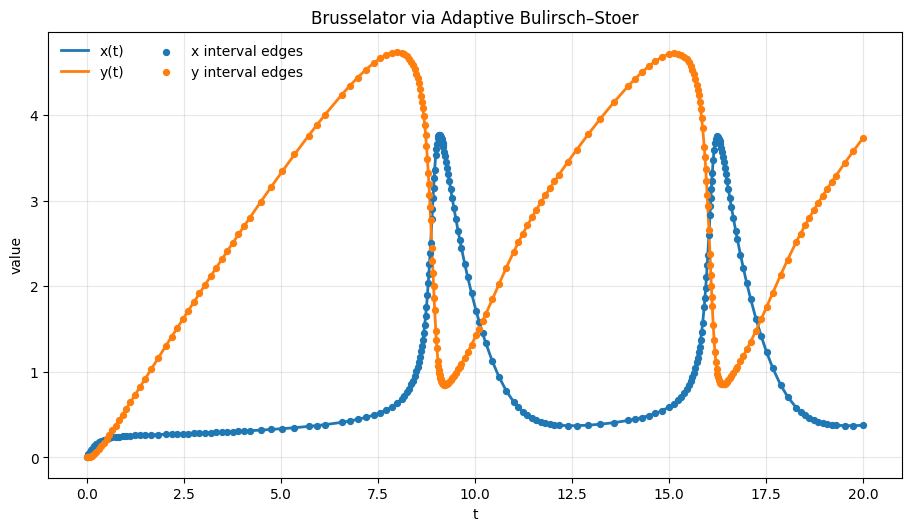

accepted=222  rejected=139


In [14]:
# Plot!

fig, ax = plt.subplots(figsize=(9, 5.2), constrained_layout=True)
ax.plot(soln["t"], soln["x"], linewidth=2, label="x(t)")
ax.plot(soln["t"], soln["y"], linewidth=2, label="y(t)")
bx = np.interp(soln["boundaries"], soln["t"], soln["x"])
by = np.interp(soln["boundaries"], soln["t"], soln["y"])
ax.scatter(soln["boundaries"], bx, s=18, zorder=3, label="x interval edges")
ax.scatter(soln["boundaries"], by, s=18, zorder=3, label="y interval edges")
ax.set_xlabel("t")
ax.set_ylabel("value")
ax.set_title("Brusselator via Adaptive Bulirsch–Stoer")
ax.grid(True, alpha=0.3)
ax.legend(frameon=False, ncol=2)
plt.show()

print(f"accepted={soln['accepted']}  rejected={soln['rejected']}")
